In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

from packet_utils import create_802154_phy_packet
from filters import gaussian_fir_taps
from demodulation import demodulate_frequency
from modulation import pulse_shape_bits_fir, modulate_frequency
from transmitter import TransmitterBLE
from receiver import ReceiverBLE

# IEEE 802.15.4
# payload -> packet (bytes)
# bytes -> chips
# bits -> IQ
# Encapsulate the process in a class

# IEEE 802.15.4

## Payload -> packet (bytes, with CRC if wanted)

In [2]:
# Example values:
payload = np.array([0xAB, 0xCD], dtype=np.uint8)
append_crc = True

packet = create_802154_phy_packet(payload, append_crc=append_crc)
print("Packet bytes:")
print(packet)
print([hex(byte) for byte in packet])

Packet bytes:
[  0   0   0   0 167   4 171 205 190  86]
['0x0', '0x0', '0x0', '0x0', '0xa7', '0x4', '0xab', '0xcd', '0xbe', '0x56']


## Half-sine shaping

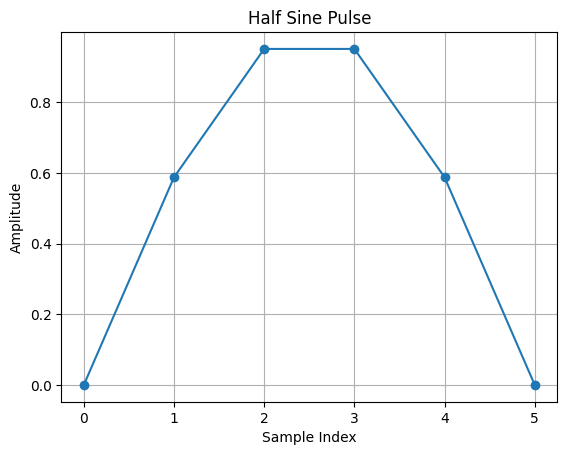

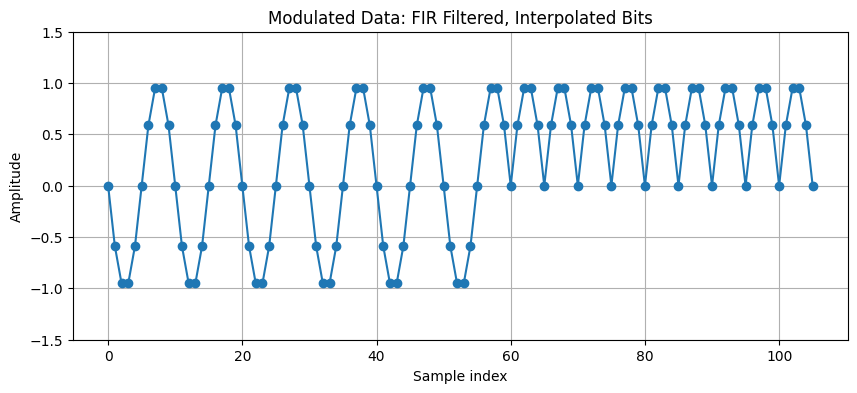

In [3]:
sps = 5
bits = np.array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

# Generate the half-sine pulse
half_sine_pulse = np.sin(np.linspace(0, np.pi, sps + 1))

# Plot the pulse
plt.figure()
plt.plot(half_sine_pulse, marker="o")
plt.title("Half Sine Pulse")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

hss_modulated_data = pulse_shape_bits_fir(bits, fir_taps=half_sine_pulse, sps=sps)

# -------------------------
# Plot the modulated data
plt.figure(figsize=(10, 4))
plt.plot(hss_modulated_data, marker="o", linestyle="-")
plt.title("Modulated Data: FIR Filtered, Interpolated Bits")
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.ylim((-1.5, 1.5))
plt.grid(True)
plt.show()